#   Credit Card Defaults.

The dataset for this assignment was collected in Taiwan in 2005, when the credit card issuers faced the cash and credit card debt crisis. In order to increase market share, card-issuing banks over-issued cash and credit cards to unqualified applicants. At the same time, most cardholders, irrespective of their repayment ability, overused credit card for consumption and accumulated heavy credit and cash–card debts. The crisis caused the blow to consumer finance confidence and was a big challenge for both banks and cardholders.

The data were collected from an important bank (a cash and credit card issuer) in Taiwan and the targets were credit card holders of the bank. Variables the dataset contains are:

·       **LIMIT_BAL**: credit limit in NT dollars (including for client's family)

·       **GENDER**: 1 = male, 2 = female

·       **EDUCATION**: 0 = doctorate, 1 = masters; 2 = bachelor; 3 = school graduate; 4 = elementary education; 5= other; 6 = no data.

·       **MARITAL**: marital status: 0 = no answer; 1 = married; 2 = single; 3 = no data.

·       **AGE**: age in years

·       **default**: binary indicator of a default (1 = Yes, 0 = No)

We would like to explore whether there are differences between customers who defaulted and did not.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.proportion import test_proportions_2indep
from scipy.stats import chi2_contingency

%matplotlib inline

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Credit limit: test whether there are differences between median credit limits of two groups.

First, let's look at the median values of "defaulted" people and "not defaulted".

In [14]:
data.groupby('default')['LIMIT_BAL'].median()

default
0    150000
1     90000
Name: LIMIT_BAL, dtype: int64

In [15]:
all_with_default_NO = data.loc[data.default == 0]  # Length: 23364
all_with_default_YES = data.loc[data.default == 1]  # Length: 6636

Let's plot the histogram of the credit limit (**LIMIT_BAL**)

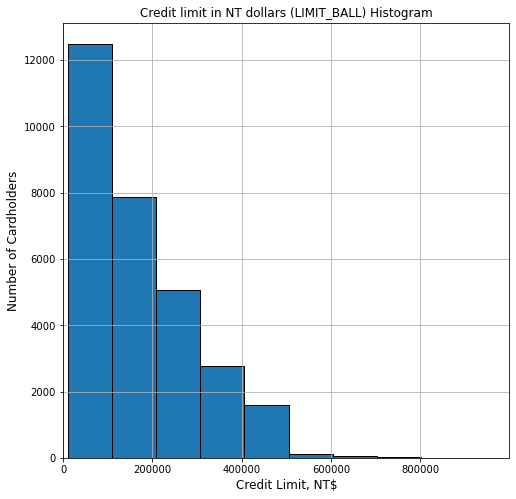

In [16]:
plt.figure(figsize=(8,8))
plt.title(f'Credit limit in NT dollars (LIMIT_BALL) Histogram')
plt.hist(data['LIMIT_BAL'], edgecolor='black');
plt.xlabel(f'Credit Limit, NT$', fontsize=12)
plt.ylabel(f'Number of Cardholders', fontsize=12)
plt.grid()
plt.xlim(0, 10**6-1);

Now let's build a comparative histogram for credit limit for cases for "default" and "not default"

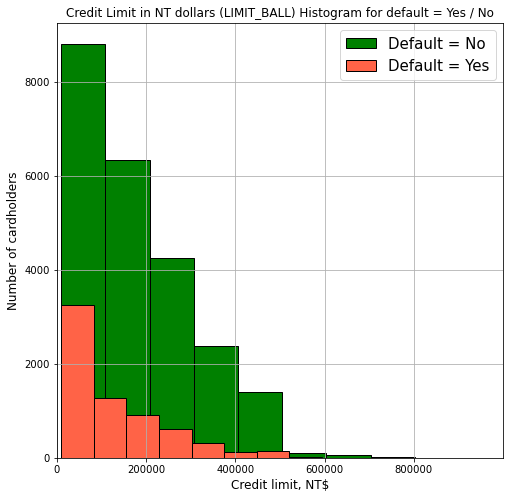

In [22]:
plt.figure(figsize=(8,8))
plt.subplot()
plt.title(f'Credit Limit in NT dollars (LIMIT_BALL) Histogram for default = Yes / No')
plt.hist(all_with_default_NO.LIMIT_BAL, color='green',edgecolor='black', label='Default = No')
plt.hist(all_with_default_YES.LIMIT_BAL, color='tomato',edgecolor='black', label='Default = Yes')
plt.xlim(0, 10**6-1)
plt.grid()
plt.xlabel(f'Credit limit, NT$', fontsize=12)
plt.ylabel(f'Number of cardholders', fontsize=12)
plt.legend(fontsize=15);

We will check that medians from two populations are equal.

**Null hypothesis**: Medians of credit limit are equal in samples of clients who paid and did not pay their debt
<br> $H_{0}: \mu_{1} = \mu_{2}$ 

**Alternative hypothesis**: medians are not equal.
<br> $H_{1}: \mu_{1} ≠ \mu_{2}$


As showen above:

In [23]:
# Median credit limit

print(f'Median credit limit for all cardholders without default: {all_with_default_NO.LIMIT_BAL.median()}')
print(f'Median credit limit for all cardholders with default: {all_with_default_YES.LIMIT_BAL.median()}')
print(f'Median credit limit for all cardholders: {data.LIMIT_BAL.median()}')

Median credit limit for all cardholders without default: 150000.0
Median credit limit for all cardholders with default: 90000.0
Median credit limit for all cardholders: 140000.0


As we want to estimate **medians**, not means, then it's better to use **Bootstrap** method. So we will estimate the confidence interval using **Bootstrap**. Bootstrapping is a resampling procedure that uses data from one sample to generate a sampling distribution by repeatedly taking random samples from the known sample, with replacement.

**Steps to create a bootstrap sample:**
1. Replace the population with the sample
2. Sample with replacement n_samples. It should be large, say 1000...5000
3. Compute sample medians each time, 
4. Obtain the approximate distribution of the sample median. To obtain, a 95% confidence interval we will find the middle 95% of the sample medians. For this, find the medians at the 2.5% and 97.5% quartiles. The 2.5th percentile will be at the position (0.025)(N + 1), and the 97.5th percentile will be at the position (0.975)(N + 1). If any of these numbers are not integers, round to the nearest integer. The values of these positions are the lower and upper limits of the 95% bootstrap interval for the median.

In [25]:
# Function to generate bootstrap samples
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

# Function for building an interval
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [26]:
#  Confidence intervals estimation

np.random.seed(0)

limit_bal_0_bst_median = list(map(np.median, get_bootstrap_samples(all_with_default_NO.LIMIT_BAL.values, 100)))
limit_bal_1_bst_median = list(map(np.median, get_bootstrap_samples(all_with_default_YES.LIMIT_BAL.values, 100)))

bnd_0 = stat_intervals(limit_bal_0_bst_median, 0.05)
bnd_1 = stat_intervals(limit_bal_1_bst_median, 0.05)

print(f'CI for default = 0: [{bnd_0[0]}, {bnd_0[1]}]')
print(f'CI for default = 1: [{bnd_1[0]}, {bnd_1[1]}]')

CI for default = 0: [150000.0, 150000.0]
CI for default = 1: [80000.0, 90000.0]


Confidence intervals do not intersect, which means that with a high degree of probability, the medians in the populations are different. In other words **medians do not match**. People who do not pay the debt usually take a smaller amount

Let test the hypothesis about the equality of distributions using one of the nonparametric test for checking the equality of means.
<br>$H_0\colon F_{X_1}(x) = F_{X_2}(x)$
<br>$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [97]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [109]:
np.random.seed(0)

res = permutation_test_2s(all_with_default_NO.LIMIT_BAL, 
                          all_with_default_YES.LIMIT_BAL, 
                          max_permutations = 1000, 
                          return_distr = True)
print(f"Permutation test: p-value = {res['p']}")

Permutation test: p-value = 0.001


The **p-value** is quite small and the null hypothesis is **rejected** at a significance level of 0.05.

The result is practically significant because the difference in the LIMIT_BAL median values is significantly larger. 
<br>There are differences between median credit limits of two groups.

#### Conclusions:
1. The median values of the two groups are not equal.
2. Confidence intervals do not intersect which means medians do not match. 
3. The p-value is less than significance level. There is a significant difference between the medians of two groups.

### 2. Gender: test whether gender composition of two groups differ.

Let's test the hypothesis that the gender of people who paid and did not pay the loan is different.

**GENDER:** 
<br>1 = male
<br>2 = female

First, let's build a histogram showing the ratio of people with and without default loans, grouped by gender.

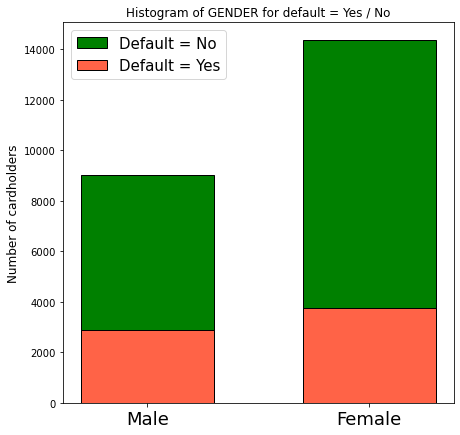

In [294]:
plt.figure(1, figsize=(7,7))
plt.subplot()
plt.title('Histogram of GENDER for default = Yes / No')
plt.hist(x=all_with_default_NO.GENDER, bins=[0.7, 1.3, 1.7, 2.3], align='mid', color='green', edgecolor='black', label='Default = No')
plt.hist(x=all_with_default_YES.GENDER, bins=[0.7, 1.3, 1.7, 2.3], align='mid', color='tomato', edgecolor='black', label='Default = Yes')
plt.xticks([1, 2], ['Male', 'Female'], fontsize=18)
plt.ylabel(f'Number of cardholders', fontsize=12)
plt.legend(fontsize=15);

**Null hypothesis**: Gender composition does not differ between the two groups:
<br>$H_0\colon$ $p_{1} = p_{2}$
 
**Alternative hypothesis**:
<br>$H_1\colon$ $p_{1} ≠ p_{2}$

In [27]:
n1 = all_with_default_YES.GENDER.count()
n2 = all_with_default_NO.GENDER.count()

N1 = (all_with_default_YES.GENDER-1).sum()
N2 = (all_with_default_NO.GENDER-1).sum()

Confidence interval for the difference in proportions:

In [44]:
interval = confint_proportions_2indep(N1, n1, N2, n2, 
                                      method='wald', 
                                      compare='diff', 
                                      alpha=0.05, 
                                      correction=True)
print(f"Wald's 95% confidence interval for a difference between proportions: [{interval[0].round(3)}, {interval[1].round(3)}]:")

Wald's 95% confidence interval for a difference between proportions: [-0.061, -0.034]:


Let's test the hypothesis of equal proportions against two-sided alternative based on **Wilson's interval test**.

In [45]:
Wilson_test = test_proportions_2indep(N1, n1, N2, n2, 
                                      alternative = 'two-sided',
                                      method = 'score',
                                      compare='diff', 
                                      correction=False,
                                      return_results=False)

print(f"Wilson's interval based test: {Wilson_test[0].round(3)}, \np-value: {Wilson_test[1]}")    
print(f"p-value < 0.05: {Wilson_test[1]<0.05}")    

Wilson's interval based test: -6.921, 
p-value: 4.4764487319331085e-12
p-value < 0.05: True


#### Conclusions:

Since the p-value is very small and it's less than the significance level of 0.05, the null hypothesis of equal proportions of men and women in the samples is **rejected**, we can say that there is a significant difference between the number of men and women in our samples. Gender may influence loan default.

### 3. Education: test whether education levels differs between two groups. If it does, then how exactly?

Let's consider how the level of education affects loan delinquencies.

**EDUCATION**:
<br>0 = doctorate,
<br>1 = masters;
<br>2 = bachelor; 
<br>3 = school graduate;
<br>4 = elementary education;
<br>5 = other; 
<br>6 = no data.

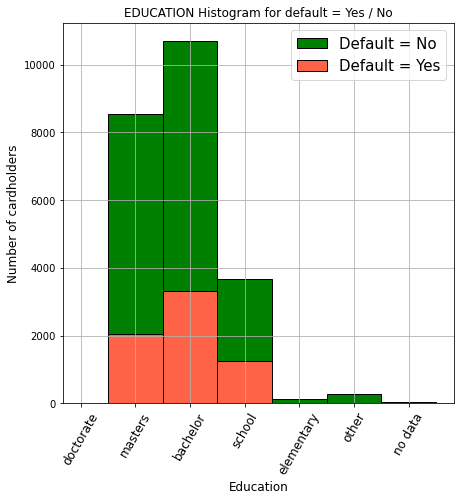

In [47]:
plt.figure(1, figsize=(7,7))
plt.subplot()
plt.title(f'EDUCATION Histogram for default = Yes / No')
plt.hist(x=all_with_default_NO.EDUCATION, 
         bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
         align='mid', color='green', edgecolor='black', label='Default = No')
plt.hist(x=all_with_default_YES.EDUCATION, 
         bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
         align='mid', color='tomato', edgecolor='black', label='Default = Yes')
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           ['doctorate', 
            'masters', 
            "bachelor", 
            "school", 
            "elementary", 
            "other", 
            "no data"], rotation=60, fontsize=12)
plt.grid()
plt.ylabel(f'Number of cardholders', fontsize=12)
plt.xlabel(f'Education', fontsize=12)
plt.legend(fontsize=15);

PhDs have no loan arrears at all, but also there are few of them in total. There is also a small percentage of non-return among those who completed only elementary school and indicated their education as "other". Significantly high defaults for school graduates, bachelors graduates and those wuth "no data". 

Let's check whether the type of education and the presence / absence of delays in paying the loan are dependent. To do this, we use the chi-square test. 
<br><br>**Null hypothesis** $H_0$: education does not affect the probability of debt default (i.e. education has a normal distribution and the influence is random)
<br><br>**Alternativehypothesis** $H_a$: education has affect on debt default.
<br>
<br>Let's build a contingency table, where the columns will be people who paid the debt, and the rows will be the level of education.

In [63]:
percent = []

for i in range(7):
    percent.append(sum(np.where(all_with_default_NO.EDUCATION == i, 1, 0)) / sum(np.where(data.EDUCATION == i, 1, 0)))

EX = np.mean(percent)
print(f'Overall expected value of loan repayment = {EX}')

contingency_table_Education = pd.DataFrame({f'default = NO': all_with_default_NO.EDUCATION.value_counts(),
                                            f'default = YES': all_with_default_YES.EDUCATION.value_counts()}).fillna(0)

contingency_table_Education

Overall expected value of loan repayment = 0.8629526580788338


,default = NO,default = YES
0,14,0.0
1,8549,2036.0
2,10700,3330.0
3,3680,1237.0
4,116,7.0
5,262,18.0
6,43,8.0


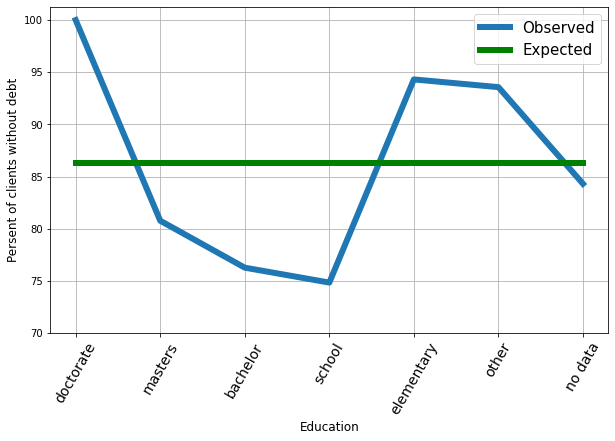

In [64]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,7,1), list(map(lambda x: (x * 100).round(2), percent)), linewidth=6, label = 'Observed')
plt.plot(np.arange(0,7,1), [EX*100 for i in range(7)], linewidth=6, label = 'Expected', color='green')
plt.xlabel(f'Education', fontsize=12)
plt.ylabel(f'Persent of clients without debt', fontsize=12)
plt.ylim(70)
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           ['doctorate', 
            'masters', 
            "bachelor", 
            "school", 
            "elementary", 
            "other", 
            "no data"], 
           rotation=60, fontsize=14)
plt.grid()
plt.legend(fontsize=15);

We will use **chi2_contingency** as we want to test whether groups with different level of education have the same distribution. We don't know the underlying distribution, but we want to test whether two (or more) groups have the same distribution. 

In [69]:
chi_2_test = chi2_contingency(contingency_table_Education, correction=False)
print (f"chi-square statistic: {chi_2_test[0].round(2)}")
print (f"p-value: {chi_2_test[1]}")
print(f"p-value < 0.05: {chi_2_test[1]<0.05}")    

chi-square statistic: 163.22
p-value: 1.2332626245415605e-32
p-value < 0.05: True


#### Conclusions:

1. From the plot and contingency table, we can see how loan defaults differ depending on the level of education.

2. Since the p-value is very small and it's less than the significance level of 0.05, the null hypothesis that education does not affect on debt default is rejected. There is a relationship between the level of education and loan payments.

### 4.  Marital status: Check how marital status is related to the default indicator: you need to propose a measure by which you can measure the possible relationship of these variables and calculate its value.

Now let's look at how marital status affects loan delinquency.

**MARITAL**: 
<br>marital status:
<br>0 = no answer; 
<br>1 = married; 
<br>2 = single; 
<br>3 = no data.

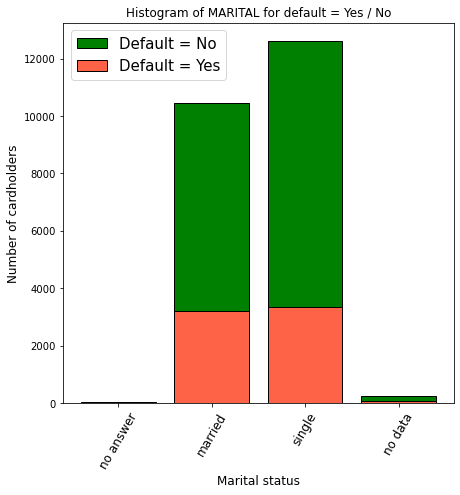

In [313]:
plt.figure(1, figsize=(7,7))
plt.subplot()
plt.title('Histogram of MARITAL for default = Yes / No')
plt.hist(x=all_with_default_NO.MARITAL,
         bins=[-0.4, 0.4, 0.6, 1.4, 1.6, 2.4, 2.6, 3.4],
         align='mid', color='green', edgecolor='black', label='Default = No')
plt.hist(x=all_with_default_YES.MARITAL, 
         bins=[-0.4, 0.4, 0.6, 1.4, 1.6, 2.4, 2.6, 3.4],
         align='mid', color='tomato', edgecolor='black', label='Default = Yes')
plt.xticks([0, 1, 2 , 3], ['no answer', 
                           'married', 
                           'single', 
                           'no data'], 
           rotation=60, fontsize=12)
plt.ylabel(f'Number of cardholders', fontsize=12)
plt.xlabel(f'Marital status', fontsize=12)
plt.legend(fontsize=15);

The share of defaults among married and single people differs by about 10%.

**Null hypothesis**: composition of married and single people in samples are the same:
<br>$H_0\colon$ $p_{1} = p_{2}$
 
**Alternative hypothesis**: composition of married and single people in samples are not the same:
<br>$H_1\colon$ $p_{1} ≠ p_{2}$

We will do as we did in 2nd question about prorotions in gender, so let's test the hypothesis of equal proportions against two-sided alternative based on **Wilson's interval test**.

In [70]:
n1 = all_with_default_YES.MARITAL.count()
n2 = all_with_default_NO.MARITAL.count()

N1 = (all_with_default_YES.MARITAL-1).sum()
N2 = (all_with_default_NO.MARITAL-1).sum()

In [71]:
Wilson_test_MARITAL = test_proportions_2indep(N1, n1, N2, n2, 
                                      alternative = 'two-sided',
                                      method = 'score',
                                      compare='diff', 
                                      correction=False,
                                      return_results=False)

print(f"Wilson's interval based test: {Wilson_test_MARITAL[0].round(3)}, \np-value: {Wilson_test_MARITAL[1]}")    
print(f"p-value < 0.05: {Wilson_test_MARITAL[1]<0.05}")  

Wilson's interval based test: -4.425, 
p-value: 9.660646237783034e-06
p-value < 0.05: True


Now we will use the **chi2_contingency test** to check the independence of marital status and default on loans.

**Null hypothesis** $H_0\colon$ marital status and default on loans are independent
<br>
 
**Alternative hypothesis** $H_1\colon$ marital status and default on loans not are independent

To perform check, we will make a contingency table:

In [72]:
contingency_table_MARITAL = pd.DataFrame({f'default = NO': all_with_default_NO.MARITAL.value_counts(),
                                          f'default = YES': all_with_default_YES.MARITAL.value_counts()})
contingency_table_MARITAL

,default = NO,default = YES
2,12623,3341
1,10453,3206
3,239,84
0,49,5


In [73]:
chi_2_test_MARITAL = chi2_contingency(contingency_table_MARITAL, correction=False)

print ("chi-square statistic: ", chi_2_test_MARITAL[0].round(2))
print ("p-value: ", chi_2_test_MARITAL[1])
print(f"p-value < 0.05: {chi_2_test_MARITAL[1]<0.05}")  

chi-square statistic:  35.66
p-value:  8.825862457577375e-08
p-value < 0.05: True


#### Conclusions:

1. p-value for the Wilson's interval test is less than the significance level of 0.05, so we rejected the null hypothesis of equal proportions of the number of single and married people.
2. p-value for the Chi squared is less than the significance level of 0.05, so null the hypothesis of independence of marital status default on loans is rejected. Marital status has an impact on default on loans.

### 5. Age: test whether there are differences between mean ages of clients in two groups.

Finally, consider the effect of age on loan delinquency.

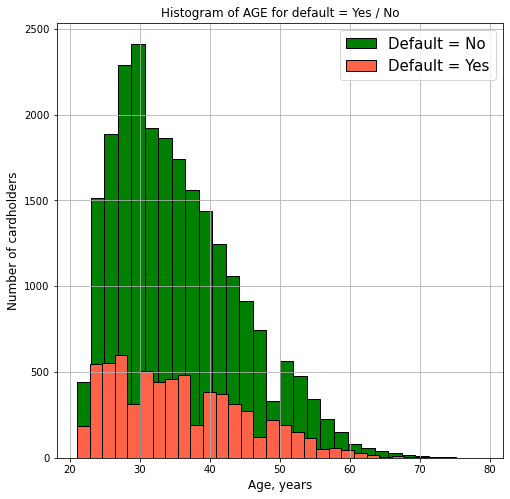

In [317]:
plt.figure(figsize=(8,8))
plt.subplot()
plt.title('Histogram of AGE for default = Yes / No')
plt.hist(all_with_default_NO.AGE, bins=30, color='green', edgecolor='black', label='Default = No')
plt.hist(all_with_default_YES.AGE, bins=30, color='tomato', edgecolor='black', label='Default = Yes')
plt.grid()
plt.xlabel(f'Age, years', fontsize=12)
plt.ylabel(f'Number of cardholders', fontsize=12)
plt.legend(fontsize=15);

**Null Hypothesis** $H_0\colon$  the means values of the credit limit for people who repaid and who did not repay the credit are equal

    
**Alternative Hypothesis** $H_1\colon$  means are different.



In [91]:
# Mean age

print(f'Mean age for all cardholders without default: {round(all_with_default_NO.AGE.mean(), 1)} years')
print(f'Mean age for all cardholders with default: {round(all_with_default_YES.AGE.mean(), 1)} years')
print(f'Mean age for all cardholders: {round(data.AGE.mean(), 1)} years')

Mean age for all cardholders without default: 35.4 years
Mean age for all cardholders with default: 35.7 years
Mean age for all cardholders: 35.5 years


Let's find confidence intervals using Bootstrap method, described in 1st question.

In [94]:
np.random.seed(0)

age_0_bst_mean = list(map(np.mean, get_bootstrap_samples(np.array(all_with_default_NO.AGE), 5000)))
age_1_bst_mean = list(map(np.mean, get_bootstrap_samples(np.array(all_with_default_YES.AGE), 5000)))

print("95% confidence interval for limit_0 mean:",  stat_intervals(age_0_bst_mean, 0.05))
print("95% confidence interval for limit_1 mean:",  stat_intervals(age_1_bst_mean, 0.05))

95% confidence interval for limit_0 mean: [35.30169492 35.53493088]
95% confidence interval for limit_1 mean: [35.49349759 35.95      ]


Confidence intervals intersect. We **cannot reject null hypothesis** that the means values of the credit limit for people who repaid and who did not repay the credit do not match

Let us test the hypothesis about the equality of distributions using one of the appropriate nonparametric tests for checking the **equality of means**. 

To test the hypothesis, a **permutation test** for independent samples is suitable.

**Null Hypothesis** $H_0\colon$ sample distributions are equal
<br>$H_0\colon F_{X_1}(x) = F_{X_2}(x)$
<br>**Alternative hypothesis** $H_1\colon$ sample distributions differ by the amount of shift
<br>$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [103]:
permutation_test = permutation_test_2s(all_with_default_NO.AGE, 
                              all_with_default_YES.AGE, 
                              max_permutations = 1000, 
                              return_distr = True)

print(f"Permutation test: p-value = {permutation_test['p']}")
print(f"p-value < 0.05: {permutation_test['p']<0.05}")  

Permutation test: p-value = 0.026
p-value < 0.05: True


In [102]:
delta_mean = np.mean(all_with_default_NO.AGE) - np.mean(all_with_default_YES.AGE)
print('Difference in means = %f' % delta_mean)

Difference in means = -0.308473


#### Conclusions:

1. As confidence intervals for BST method intersect we **cannot reject null hypothesis** that the means values of the credit limit for people who repaid and who did not repay the credit do not match. This result is of practical importance - the probability of default on loans does not depend on the age of the client.

2. p-value for the permutation test is less than the significance level of 0.05, so we **rejected the null hypothesis** of equal sample distributions. The result is statistically significant, the difference in distributions is visible and these data can be taken into account when issuing a loan. But in practice, the difference in age mean values is **less than half a year**, so from a practical point of view, the significance of these results can be called into question.